In [1]:
import os

import numpy as np
import xarray as xr

In [2]:
import cartopy.crs as ccrs
import cartopy.feature as cf

import matplotlib.patches as mpatches
import matplotlib.pyplot as plt

%matplotlib inline
%config InlineBackend.figure_format='retina'

In [3]:
from dask.distributed import Client, LocalCluster
cluster = LocalCluster(n_workers=16, threads_per_worker=4)
client = Client(cluster)

/perm/syma/conda-envs/shared/gnn-pyg-2.1/lib/python3.9/site-packages/distributed/node.py:183: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 46305 instead
  warnings.warn(
2022-11-17 15:32:41,905 - distributed.diskutils - INFO - Found stale lock file and directory '/dev/shm/_tmpdir_.syma.39648265/dask-worker-space/worker-1bthcio1', purging
2022-11-17 15:32:41,905 - distributed.diskutils - INFO - Found stale lock file and directory '/dev/shm/_tmpdir_.syma.39648265/dask-worker-space/worker-nvmrgcku', purging


In [4]:
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:46305/status,
Dashboard: http://127.0.0.1:46305/status,Workers: 16
Total threads: 64,Total memory: 128.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:39317,Workers: 16
Dashboard: http://127.0.0.1:46305/status,Total threads: 64
Started: Just now,Total memory: 128.00 GiB
Comm: tcp://127.0.0.1:45335,Total threads: 4
Dashboard: http://127.0.0.1:32823/status,Memory: 8.00 GiB
Nanny: tcp://127.0.0.1:41381,


In [5]:
# run the big computation
train_data_file_template = "/ec/res4/hpcperm/syma/WeatherBench/netcdf/training/*.nc"
era = xr.open_mfdataset(train_data_file_template, parallel=True, chunks={"time": 50})
era = era.assign_coords({"longitude": (((era.longitude + 180) % 360) - 180)})
era = era.sortby("longitude").sortby("latitude")
era

,Array,Chunk
Bytes,170.58 GiB,161.57 MiB
Shape,"(54056, 13, 181, 360)","(50, 13, 181, 360)"
Count,77 Graph Layers,1110 Chunks
Type,float32,numpy.ndarray
,Array,Chunk
Bytes,170.58 GiB,161.57 MiB
Shape,"(54056, 13, 181, 360)","(50, 13, 181, 360)"
Count,77 Graph Layers,1110 Chunks
Type,float32,numpy.ndarray
,Array,Chunk


In [7]:
# this will take roughly half an hour
era_mu = era.mean().compute()
era_sd = era.std(("time", "level")).mean(("latitude", "longitude")).compute()

In [8]:
era_mu

<xarray.Dataset>
Dimensions:  ()
Data variables:
    z        float32 7.776e+04
    t        float32 243.0
    q        float32 0.001763
    w        float32 0.004084
    u        float32 7.214
    v        float32 0.02791

In [9]:
era_sd

<xarray.Dataset>
Dimensions:  ()
Data variables:
    z        float32 5.935e+04
    t        float32 27.35
    q        float32 0.002683
    w        float32 0.1151
    u        float32 11.81
    v        float32 8.726

In [10]:
era_mu.to_netcdf("/ec/res4/hpcperm/syma/WeatherBench/netcdf/era_mu_1979_2015_new.nc")
era_sd.to_netcdf("/ec/res4/hpcperm/syma/WeatherBench/netcdf/era_sd_1979_2015_new.nc")

In [11]:
plev = 13
for l in range(plev):
    tscal = (era["t"].isel(time=399,level=l) - era_mu.t) / era_sd.t
    print(f"level = {l}: min_t: {tscal.min().values:.3f}, max_t: {tscal.max().values:.3f}")

level = 0: min_t: -1.516, max_t: -0.582
level = 1: min_t: -2.137, max_t: -0.489
level = 2: min_t: -1.576, max_t: -0.430
level = 3: min_t: -1.424, max_t: -0.306
level = 4: min_t: -1.338, max_t: -0.238
level = 5: min_t: -1.129, max_t: 0.144
level = 6: min_t: -0.941, max_t: 0.657
level = 7: min_t: -0.580, max_t: 1.060
level = 8: min_t: -0.741, max_t: 1.506
level = 9: min_t: -0.837, max_t: 1.737
level = 10: min_t: -0.529, max_t: 2.147
level = 11: min_t: -0.396, max_t: 2.373
level = 12: min_t: -0.272, max_t: 2.578


In [12]:
for l in range(plev):
    uscal = (era["u"].isel(time=4872,level=l) - era_mu.u) / era_sd.u
    print(f"level = {l}: min_u: {uscal.min().values:.3f}, max_u: {uscal.max().values:.3f}")

level = 0: min_u: -2.381, max_u: 3.025
level = 1: min_u: -1.901, max_u: 3.182
level = 2: min_u: -2.721, max_u: 4.770
level = 3: min_u: -2.491, max_u: 6.239
level = 4: min_u: -2.813, max_u: 6.523
level = 5: min_u: -3.305, max_u: 5.888
level = 6: min_u: -3.861, max_u: 4.854
level = 7: min_u: -3.540, max_u: 3.685
level = 8: min_u: -2.927, max_u: 2.807
level = 9: min_u: -2.759, max_u: 2.314
level = 10: min_u: -3.067, max_u: 2.404
level = 11: min_u: -2.850, max_u: 1.888
level = 12: min_u: -2.140, max_u: 1.183


In [13]:
for l in range(plev):
    qscal = (era["q"].isel(time=18723,level=l) - era_mu.q) / era_sd.q
    print(f"level = {l}: min_q: {qscal.min().values:.3f}, max_q: {qscal.max().values:.3f}")

level = 0: min_q: -0.656, max_q: -0.656
level = 1: min_q: -0.657, max_q: -0.655
level = 2: min_q: -0.656, max_q: -0.644
level = 3: min_q: -0.656, max_q: -0.562
level = 4: min_q: -0.656, max_q: -0.343
level = 5: min_q: -0.656, max_q: 0.004
level = 6: min_q: -0.657, max_q: 1.004
level = 7: min_q: -0.656, max_q: 2.184
level = 8: min_q: -0.657, max_q: 3.627
level = 9: min_q: -0.657, max_q: 4.752
level = 10: min_q: -0.657, max_q: 6.231
level = 11: min_q: -0.653, max_q: 6.904
level = 12: min_q: -0.653, max_q: 7.209


In [14]:
for l in range(plev):
    zscal = (era["z"].isel(time=100,level=l) - era_mu.z) / era_sd.z
    print(f"level = {l}: min_z: {zscal.min().values:.3f}, max_z: {zscal.max().values:.3f}")

level = 0: min_z: 1.830, max_z: 2.126
level = 1: min_z: 1.165, max_z: 1.445
level = 2: min_z: 0.759, max_z: 1.055
level = 3: min_z: 0.466, max_z: 0.757
level = 4: min_z: 0.236, max_z: 0.511
level = 5: min_z: 0.046, max_z: 0.299
level = 6: min_z: -0.253, max_z: -0.048
level = 7: min_z: -0.492, max_z: -0.331
level = 8: min_z: -0.703, max_z: -0.569
level = 9: min_z: -0.892, max_z: -0.778
level = 10: min_z: -1.145, max_z: -1.038
level = 11: min_z: -1.260, max_z: -1.150
level = 12: min_z: -1.366, max_z: -1.252


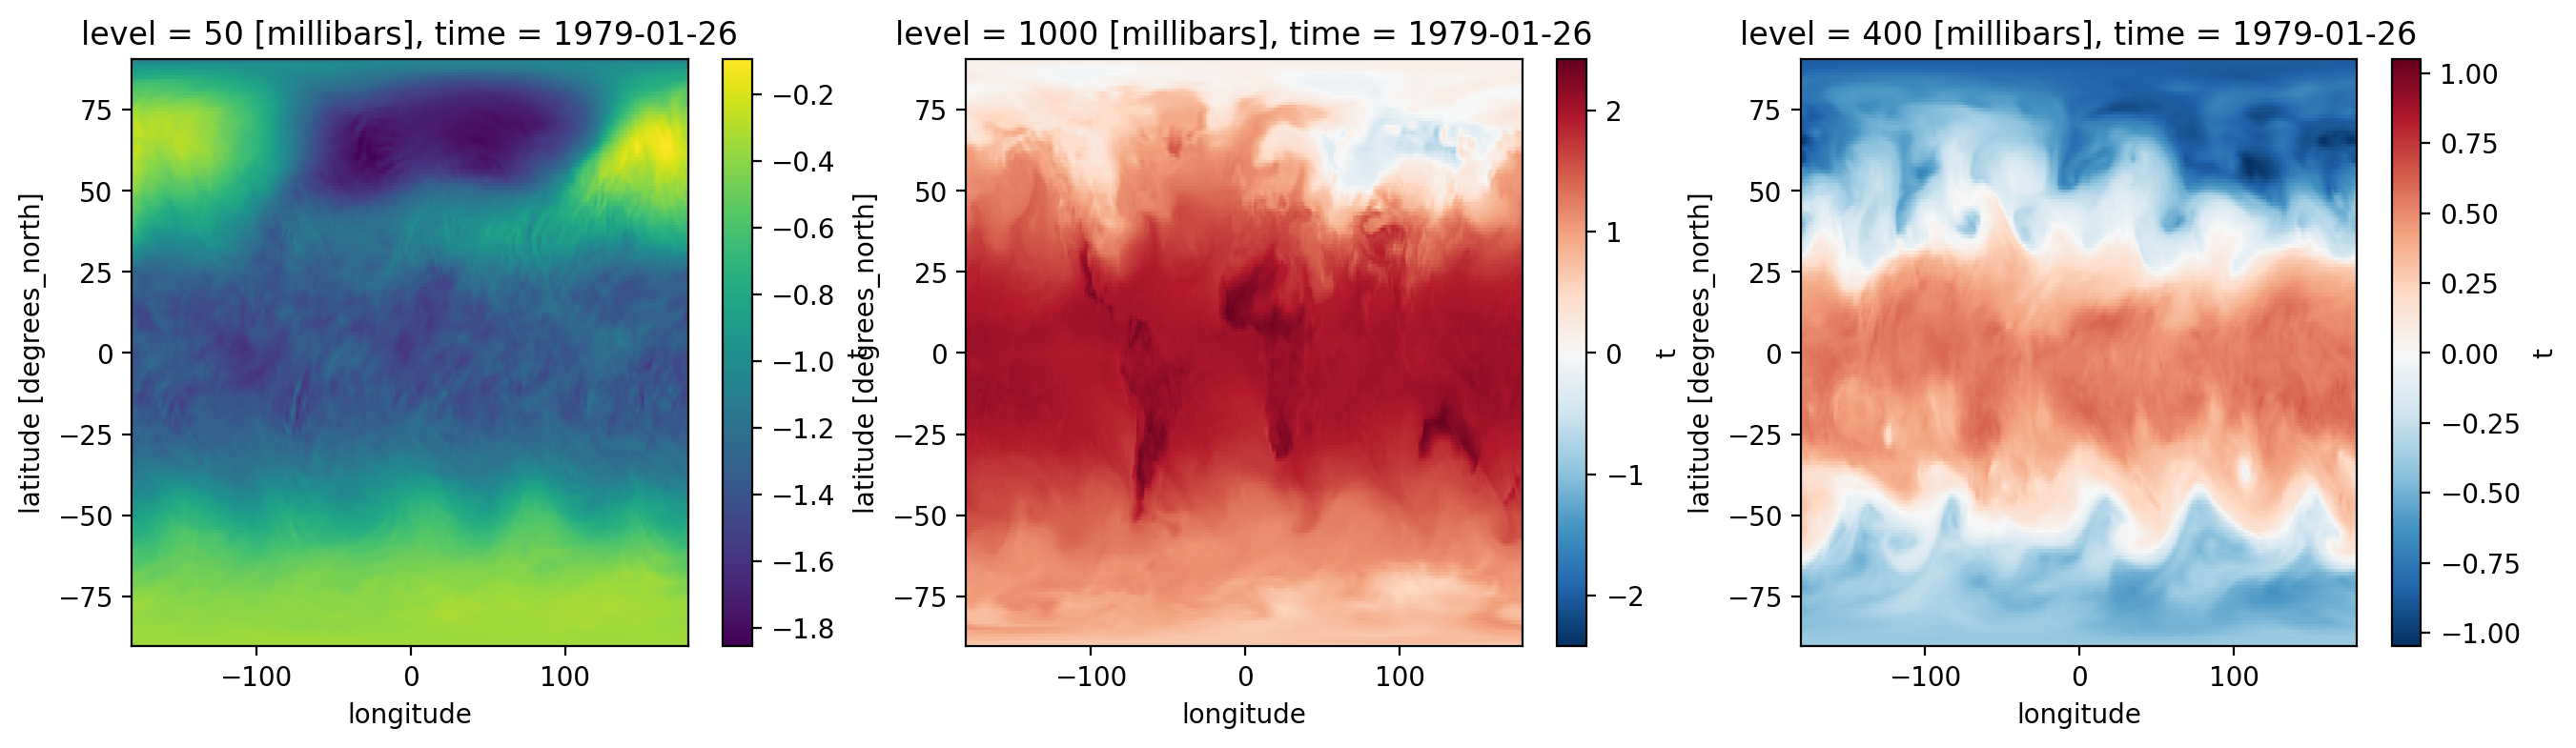

In [18]:
fig, ax = plt.subplots(1, 3, figsize=(16, 4))

t_scal_50 = (era["t"].isel(time=100,level=0) - era_mu.t) / era_sd.t
t_scal_50.plot(ax=ax[0]);

t_scal_1000 = (era["t"].isel(time=100,level=-1) - era_mu.t) / era_sd.t
t_scal_1000.plot(ax=ax[1]);

t_scal_400 = (era["t"].isel(time=100,level=6) - era_mu.t) / era_sd.t
t_scal_400.plot(ax=ax[2]);

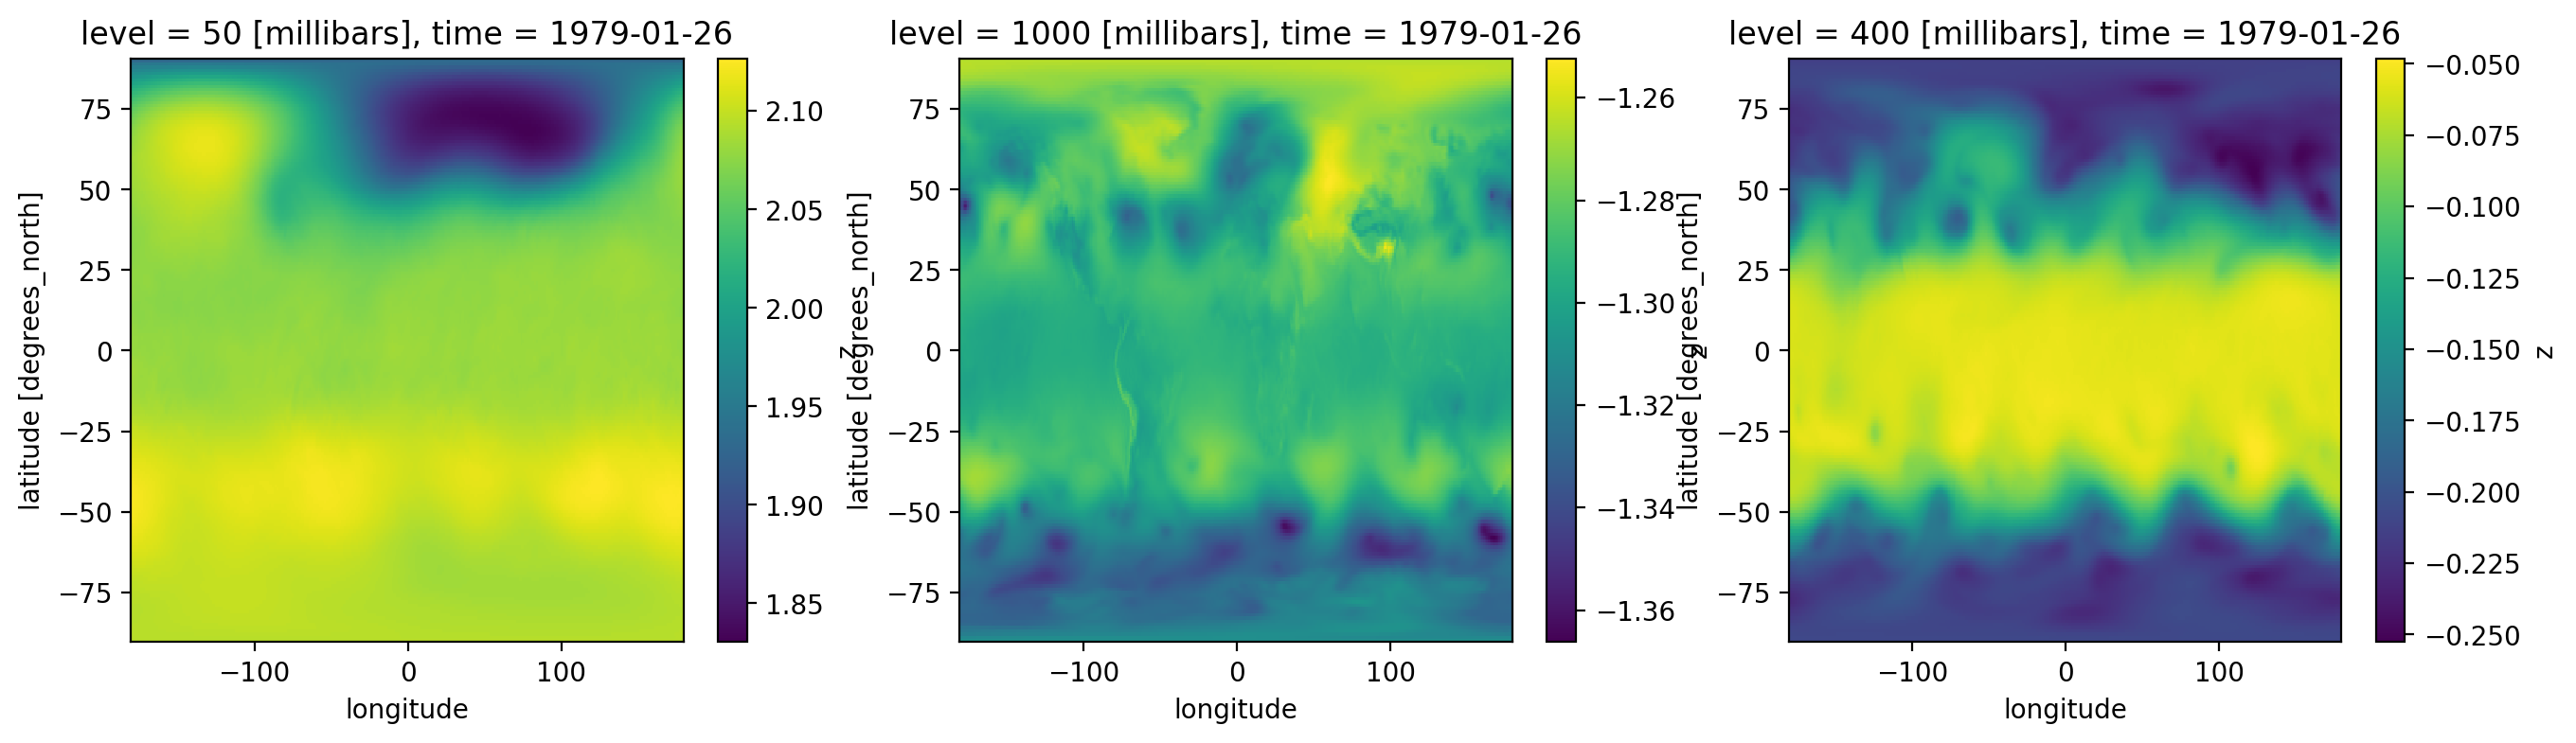

In [16]:
fig, ax = plt.subplots(1, 3, figsize=(16, 4))

z_scal_50 = (era["z"].isel(time=100,level=0) - era_mu.z) / era_sd.z
z_scal_50.plot(ax=ax[0])
z_scal_1000 = (era["z"].isel(time=100,level=-1) - era_mu.z) / era_sd.z
z_scal_1000.plot(ax=ax[1])
z_scal_400 = (era["z"].isel(time=100,level=6) - era_mu.z) / era_sd.z
z_scal_400.plot(ax=ax[2]);

In [17]:
era_mu_old = xr.load_dataset("/ec/res4/hpcperm/syma/WeatherBench/netcdf/means-1979-2015.nc")
era_sd_old = xr.load_dataset("/ec/res4/hpcperm/syma/WeatherBench/netcdf/sds-1979-2015.nc")

In [19]:
era_mu_old, era_sd_old

(<xarray.Dataset>
 Dimensions:  ()
 Data variables:
     z        float32 7.776e+04
     t        float32 243.0
     q        float32 0.001763
     w        float32 0.004084
     u        float32 7.214
     v        float32 0.02791,
 <xarray.Dataset>
 Dimensions:  ()
 Data variables:
     z        float32 1.48e+03
     t        float32 5.403
     q        float32 0.0007088
     w        float32 0.09496
     u        float32 9.359
     v        float32 8.033)

In [20]:
era_mu, era_sd

(<xarray.Dataset>
 Dimensions:  ()
 Data variables:
     z        float32 7.776e+04
     t        float32 243.0
     q        float32 0.001763
     w        float32 0.004084
     u        float32 7.214
     v        float32 0.02791,
 <xarray.Dataset>
 Dimensions:  ()
 Data variables:
     z        float32 5.935e+04
     t        float32 27.35
     q        float32 0.002683
     w        float32 0.1151
     u        float32 11.81
     v        float32 8.726)